# Start

This script cleans field data from Nick's PhD and enriches it with slope, aspect, relief, and vegetation cover values.

## 📄 **What this script does**
1. **Cleans** the field data by selecting only observations where `Height` equals 1, and `Datetime` is after the installation date/time and before the removal date/time.
2. Removes all columns except `SiteID`, `X`, `Y`, `Datetime`, `C`, and `RH`. The `C` column is renamed to `Temperature`.
3. **Corrects relative humidity** (`RH`) using equations from the supplementary material of this publication: [https://doi.org/10.1016/j.agrformet.2013.03.008](https://doi.org/10.1016/j.agrformet.2013.03.008).
4. **Calculates VPD** (vapor pressure deficit) from the corrected temperature and RH.
5. Generates `site_data_summary.csv`, which contains the list of each site (with X and Y coordinates) and the dates for which data is available.
6. For each site in `sites_df`, **fills in slope, aspect, and relief** using precomputed `.tif` files from `topography_calculation.ipynb`. These topographic values are then used to enrich the full field dataset.
7. The vegetation cover data is derived from the `veg_cover` field of the DEA Fractional Cover product, retrieved via the ARE NCI. For each observation, **the `veg_cover` value is taken from the `veg_cover` data point closest in time and location.**
8. The resulting observations, with their slope, aspect, relief, and vegetation cover, are saved as `in-situ_topography.csv`.

## ⚠️ **Important notes**
* **Before running the script**, set all variables in the first cell, and delete the second cell if not using a Google Colab environment.  
  *(The script was developed for use in Google Colab and has not been tested outside of it.)*
* The `DEA_Fractional_cover_veg_cover.nc` file, which contains vegetation cover data from the DEA Fractional Cover product, has an incorrect `crs` attribute. The correct coordinate reference system is EPSG:32754.
* For site observations that the corresponding vegetation cover data in DEA Fractional Cover product are `NaN`s, **the nearest valid vegetation cover values in time are used.**

# TODO (MEDIUM): Edit veg_cover related content






In [30]:
# Set variables
data_file_name = "T_RH_2020-11-10(in).csv"
data_url = "https://anu365.sharepoint.com/:x:/r/sites/ANU-OptusBushfireResearchCoE/Shared%20Documents/Projects/2024_5%20NSSN%20FMC%20monitoring/T_RH_2020-11-10.csv?d=w7e97fe709fc24f839be6d929d48bde0e&csf=1&web=1&e=3XhSoD"
working_dir = "/content/drive/My Drive/Work/2025.04 ANU Bushfire"

In [31]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Generate output directory

import os
output_dir = os.path.join(working_dir, "output/csv")
os.makedirs(output_dir, exist_ok=True)

In [33]:
# Download data with a link

import os
import requests

def download_file(url, filename):
  try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes

    with open(filename, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
    print(f"Data downloaded successfully to {filename}")
  except requests.exceptions.RequestException as e:
    print(f"Error downloading data: {e}")

data_path = os.path.join(working_dir, data_file_name)
if not os.path.exists(data_path):
    download_file(data_url, data_path)

# Read and explore the data

In [34]:
# Read data

import pandas as pd

df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
df.head()

<ipython-input-34-c191edd1b734>:5: DtypeWarning: Columns (17,20,25,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,Unnamed: 0,Date,Logger,SurveyID,SiteID,Site Number.x,Cluster,Open,N_S,Instalation date,Instalation time,Instalation,Removal date,Removal time,Removal,Anemometer,Anemometer orientation,iButton (1m),Comments.x,Height,iButton (ground),RH,C,Site Number.y,State Forest,Topo,Orientation,Region,X,Y,Date of last Logging,LYear,Date Thinning,TYear,Date of last wildfire,FYear,Date of last prescribed fire,HRYear,Dom Tree1,Dom Tree2,Dom Tree3,Dom Tree4,Dom Tree5,Dom Shrub1,Dom Shrub2,Dom Shrub3,Dom Shrub4,Dom Shrub5,Aspect,Slope,Elevation,Rainfall,Temperature,Insolation,VPD,Comments.y,SurveyYear,Lyear,Tyear,TST,TSL,Fyear,TSF,HRyear,TSHR,TSLd,TSFd,HR,Thin,day
0,1,1/20/2019 4:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,101.843,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00
1,2,1/20/2019 5:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.084,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00
2,3,1/20/2019 6:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,101.723,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00
3,4,1/20/2019 7:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.084,18.875,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00
4,5,1/20/2019 8:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.684,19.813,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230993 entries, 0 to 230992
Data columns (total 70 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    230993 non-null  int64  
 1   Date                          230993 non-null  object 
 2   Logger                        230993 non-null  object 
 3   SurveyID                      230993 non-null  int64  
 4   SiteID                        230993 non-null  int64  
 5   Site Number.x                 230993 non-null  object 
 6   Cluster                       229809 non-null  float64
 7   Open                          229809 non-null  float64
 8   N_S                           229809 non-null  object 
 9   Instalation date              230993 non-null  object 
 10  Instalation time              230993 non-null  int64  
 11  Instalation                   230993 non-null  object 
 12  Removal date                  230993 non-nul

# Data cleaning and correction

In [36]:
# Convert all dates into datetime objects

from datetime import datetime

format = '%m/%d/%Y %H:%M'

df['Instalation time'] = df['Instalation time'].astype(str).str.zfill(4)
datetime_str = df['Instalation date'].astype(str) + ' ' + df['Instalation time'].str.slice(0, 2) + ':' + df['Instalation time'].str.slice(2, 4)
df['Instalation datetime'] = pd.to_datetime(datetime_str, format=format)

df['Removal time'] = df['Removal time'].astype(str).str.zfill(4)
datetime_str = df['Removal date'].astype(str) + ' ' + df['Removal time'].str.slice(0, 2) + ':' + df['Removal time'].str.slice(2, 4)
df['Removal datetime'] = pd.to_datetime(datetime_str, format=format)

df['Date'] = pd.to_datetime(df['Date'], format=format)
df = df.rename(columns={'Date': 'Datetime'})

df.head()

,Unnamed: 0,Datetime,Logger,SurveyID,SiteID,Site Number.x,Cluster,Open,N_S,Instalation date,Instalation time,Instalation,Removal date,Removal time,Removal,Anemometer,Anemometer orientation,iButton (1m),Comments.x,Height,iButton (ground),RH,C,Site Number.y,State Forest,Topo,Orientation,Region,X,Y,Date of last Logging,LYear,Date Thinning,TYear,Date of last wildfire,FYear,Date of last prescribed fire,HRYear,Dom Tree1,Dom Tree2,Dom Tree3,Dom Tree4,Dom Tree5,Dom Shrub1,Dom Shrub2,Dom Shrub3,Dom Shrub4,Dom Shrub5,Aspect,Slope,Elevation,Rainfall,Temperature,Insolation,VPD,Comments.y,SurveyYear,Lyear,Tyear,TST,TSL,Fyear,TSF,HRyear,TSHR,TSLd,TSFd,HR,Thin,day,Instalation datetime,Removal datetime
0,1,2019-01-20 04:00:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,0900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,101.843,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00,2019-01-16 14:30:00,2019-01-30 09:00:00
1,2,2019-01-20 05:00:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,0900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.084,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00,2019-01-16 14:30:00,2019-01-30 09:00:00
2,3,2019-01-20 06:00:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,0900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,101.723,18.436,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00,2019-01-16 14:30:00,2019-01-30 09:00:00
3,4,2019-01-20 07:00:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,0900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.084,18.875,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00,2019-01-16 14:30:00,2019-01-30 09:00:00
4,5,2019-01-20 08:00:00,180000005AFDA141,13,80,P4,1.0,1.0,S,1/16/2019,1430,1/16/2019 17:45,1/30/2019,0900,1/30/2019 9:00,EM46546,340.0,50000000616D1E41,NaN,zero,NaN,102.684,19.813,P4,North Brooman,NaN,NaN,South Coast,150.298026,-35.475063,1/1/2017,2017,NaN,NaN,1/1/1994,1994.0,1/1/2017,2017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.701996,12.4222,140.0,1111,15.7167,16677.59961,1.30917,NaN,2019,2016,NaN,NaN,3,1993.0,26.0,2016.0,3.0,10,30.0,Y,N,1/20/2019 0:00,2019-01-16 14:30:00,2019-01-30 09:00:00


In [37]:
# Data cleaning

df = df[df['Height'] != 'zero']  # 120 to 108 sites
df = df[(df['Datetime'] > df['Instalation datetime']) & (df['Datetime'] < df['Removal datetime'])]  # 108 to 103 sites
df = df[['SiteID', 'X', 'Y', 'Datetime', 'C', 'RH']]
df = df.rename(columns={'C': 'Temperature'})
df.head()

,SiteID,X,Y,Datetime,Temperature,RH
107963,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,100.500
107964,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,100.867
107965,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,101.233
107966,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,100.377
107967,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,100.867


In [38]:
print(df.info())

print("Latlon bound of dataframe")
df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()

print("Datetime bound of dataframe")
df['Datetime'].min(), df['Datetime'].max()

<class 'pandas.core.frame.DataFrame'>
Index: 115157 entries, 107963 to 230992
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   SiteID       115157 non-null  int64         
 1   X            115157 non-null  float64       
 2   Y            115157 non-null  float64       
 3   Datetime     115157 non-null  datetime64[ns]
 4   Temperature  115157 non-null  float64       
 5   RH           115157 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 6.2 MB
None
Latlon bound of dataframe
Datetime bound of dataframe


(Timestamp('2018-12-21 12:13:00'), Timestamp('2020-11-06 08:59:00'))

In [39]:
# Handle 'RH' > 100

# Find MaxRH for each site and date
df['Date'] = df.apply(lambda row: row['Datetime'].date(), axis=1)
df['MaxRH'] = df.groupby(['SiteID', 'Date'])['RH'].transform('max')

# Find MaxRH95 for each site
df['MaxRH95'] = df.groupby(['SiteID'])['MaxRH'].transform(lambda x: x.quantile(0.95))

# Apply correction the RH values. If RH is greater than MaxRH95, RH = 100, else RH = RH*100/MaxRH95
df['RH'] = df.apply(lambda row: 100 if (row['RH'] > row['MaxRH95']) | (row['RH'] < 0) else  row['RH'] * 100 / row['MaxRH95'], axis=1)
df

,SiteID,X,Y,Datetime,Temperature,RH,Date,MaxRH,MaxRH95
107963,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,97.525473,2019-01-20,101.233,103.050
107964,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,97.881611,2019-01-20,101.233,103.050
107965,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,98.236778,2019-01-20,101.233,103.050
107966,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,97.406114,2019-01-20,101.233,103.050
107967,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,97.881611,2019-01-20,101.233,103.050
...,...,...,...,...,...,...,...,...,...
230988,264,150.0700,-36.14200,2020-03-25 08:13:00,16.058,97.426485,2020-03-25,103.802,105.148
230989,264,150.0700,-36.14200,2020-03-25 08:23:00,16.058,97.426485,2020-03-25,103.802,105.148
230990,264,150.0700,-36.14200,2020-03-25 08:33:00,16.058,97.426485,2020-03-25,103.802,105.148
230991,264,150.0700,-36.14200,2020-03-25 08:43:00,16.058,97.426485,2020-03-25,103.802,105.148


In [40]:
# Check the correctness of the calculation
# df.groupby(['MaxRH95'])['SiteID'].apply(lambda x: x.unique()).reset_index()

df.drop(columns=['MaxRH', 'MaxRH95', 'Date'], inplace=True)
df.head()

,SiteID,X,Y,Datetime,Temperature,RH
107963,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,97.525473
107964,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,97.881611
107965,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,98.236778
107966,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,97.406114
107967,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,97.881611


In [41]:
# Calculate VPD

import numpy as np
import math

def calculate_vpd(temp, rh):
    if pd.isna(temp) or pd.isna(rh):
        return np.nan
    es = 0.6108 * math.exp(17.27 * temp / (237.3 + temp))
    e = es * rh / 100
    vpd = es - e
    return vpd

df['VPD'] = df.apply(lambda row: calculate_vpd(row['Temperature'], row['RH']), axis=1)
df.head()

,SiteID,X,Y,Datetime,Temperature,RH,VPD
107963,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,97.525473,0.050885
107964,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,97.881611,0.043049
107965,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,98.236778,0.036114
107966,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,97.406114,0.053760
107967,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,97.881611,0.044776


# Get a list of each site (x and y coordinates) and the dates we have data for.

In [42]:
# Group by SiteID, X, Y and collect unique sorted dates
sites_df = (
    df.groupby(['SiteID', 'X', 'Y'])['Datetime']
    .apply(lambda x: ', '.join(sorted(x.dt.strftime('%Y-%m-%d').unique())))
    .reset_index()  # Convert the data in Series to DataFrame
    .rename(columns={'Datetime': 'Dates'})
)
sites_df

,SiteID,X,Y,Dates
0,67,150.2697,-35.54484,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24..."
1,68,150.2689,-35.54393,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24..."
2,69,150.2683,-35.54516,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24..."
3,70,150.2675,-35.54480,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24..."
4,71,150.2904,-35.48805,"2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06..."
...,...,...,...,...
98,296,150.2439,-35.62358,"2020-10-14, 2020-10-15, 2020-10-16, 2020-10-17..."
99,302,150.3096,-35.46728,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23..."
100,303,150.3111,-35.46382,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23..."
101,304,150.3088,-35.46669,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23..."


In [43]:
# Save to CSV
sites_df.to_csv(os.path.join(output_dir, 'site_data_summary.csv'), index=False)

# Add biophysical properties into dataframe

In [44]:
!pip install rasterio

## Fill in slope, aspect, and relief of each site

In [45]:
# Add slope, aspect, and relief data
# TODO (LOW) : The biophysical data are retrieved several time for each sites. Make it more efficient.

import rasterio
from rasterio.merge import merge
from rasterio.transform import rowcol
from rasterio.warp import transform
import glob
import os
import numpy as np

def get_value_from_latlon(data, crs, trans, x, y):
    # Find corresponding row and column with latlon
    x_proj, y_proj = transform('EPSG:4326', crs, [x], [y])
    row, col = rowcol(trans, x_proj, y_proj)

    try:
        return data[row, col][0]
    except:
        print(f"There is a row with lon {x}, lat {y} outside tif files' area. The value is set to np.nan")
        return np.nan

def add_data_to_df(property, df):
    # TODO (LOW): There is no more need to merge all tif files.
    # Find all related tif files
    files = glob.glob(os.path.join(working_dir, 'output', f"*{property}.tif"))
    print(f"There are {len(files)} {property} files: {files}")

    # Merge all tif files
    src_files_to_mosaic = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(src_files_to_mosaic)
    data = mosaic[0]

    # Add data to df
    crs = src_files_to_mosaic[0].crs
    # # TODO (LOW): I was trying to resolving rows and cols calculation redundancy
    # if "temp_row" not in df.columns or "temp_col" not in df.columns:
    #     x_proj, y_proj = transform('EPSG:4326', crs, df['X'], df['Y'])
    #     df['temp_row'], df['temp_col'] = rowcol(out_trans, x_proj, y_proj)
    # df[property] = df.apply(lambda row: data[row['temp_row'], row['temp_col']], axis=1)
    df[property] = df.apply(lambda row: get_value_from_latlon(data, crs, out_trans, row['X'], row['Y']), axis=1)
    return df

In [46]:
sites_df = add_data_to_df('slope', sites_df)
sites_df = add_data_to_df('aspect', sites_df)
sites_df = add_data_to_df('relief', sites_df)
df['slope'] = df['slope'].round(2)
df['aspect'] = df['aspect'].round(1)
df['relief'] = df['relief'].round(2)
sites_df

There are 3 slope files: ['/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/coffs_harbour_slope.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/port_macquarie_slope.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_slope.tif']
There are 3 aspect files: ['/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/coffs_harbour_aspect.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/port_macquarie_aspect.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_aspect.tif']
There are 3 relief files: ['/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/coffs_harbour_relief.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/port_macquarie_relief.tif', '/content/drive/My Drive/Work/2025.04 ANU Bushfire/output/batemans_bay_relief.tif']


,SiteID,X,Y,Dates,slope,aspect,relief
0,67,150.2697,-35.54484,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24...",9.808307,91.473587,63.235474
1,68,150.2689,-35.54393,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24...",10.307602,14.475945,63.083405
2,69,150.2683,-35.54516,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24...",13.346684,181.494461,64.185143
3,70,150.2675,-35.54480,"2018-12-21, 2018-12-22, 2018-12-23, 2018-12-24...",11.395288,220.262634,65.372086
4,71,150.2904,-35.48805,"2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06...",7.369228,7.677246,26.131332
...,...,...,...,...,...,...,...
98,296,150.2439,-35.62358,"2020-10-14, 2020-10-15, 2020-10-16, 2020-10-17...",11.457701,128.719116,13.985332
99,302,150.3096,-35.46728,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23...",10.316882,10.491440,50.911789
100,303,150.3111,-35.46382,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23...",10.186744,340.197449,32.839523
101,304,150.3088,-35.46669,"2020-10-20, 2020-10-21, 2020-10-22, 2020-10-23...",9.946544,19.776672,36.053635


In [47]:
# Investigate missing values
# TODO (MEDIUM): There are 5 sites in total with NaNs. Explore whether we can leave it as is.
# NOTE: Site id 251 has row: [23133], col: [1081].
sites_with_nans_df = sites_df[(sites_df['slope'].isna()) | (sites_df['aspect'].isna()) | (sites_df['relief'].isna())]
sites_with_nans_df

,SiteID,X,Y,Dates,slope,aspect,relief
64,251,150.155,-36.141,"2020-02-18, 2020-02-19, 2020-02-20, 2020-02-21...",NaN,NaN,0.0


In [48]:
# Add the properties to df
df = df.merge(sites_df[["SiteID", "slope", "aspect", "relief"]], on=['SiteID'], how='left')
df

,SiteID,X,Y,Datetime,Temperature,RH,VPD,slope,aspect,relief
0,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,97.525473,0.050885,7.769969,187.297363,27.341133
1,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,97.881611,0.043049,7.769969,187.297363,27.341133
2,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,98.236778,0.036114,7.769969,187.297363,27.341133
3,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,97.406114,0.053760,7.769969,187.297363,27.341133
4,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,97.881611,0.044776,7.769969,187.297363,27.341133
...,...,...,...,...,...,...,...,...,...,...
115152,264,150.0700,-36.14200,2020-03-25 08:13:00,16.058,97.426485,0.046968,4.512023,337.422852,-12.584137
115153,264,150.0700,-36.14200,2020-03-25 08:23:00,16.058,97.426485,0.046968,4.512023,337.422852,-12.584137
115154,264,150.0700,-36.14200,2020-03-25 08:33:00,16.058,97.426485,0.046968,4.512023,337.422852,-12.584137
115155,264,150.0700,-36.14200,2020-03-25 08:43:00,16.058,97.426485,0.046968,4.512023,337.422852,-12.584137


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115157 entries, 0 to 115156
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   SiteID       115157 non-null  int64         
 1   X            115157 non-null  float64       
 2   Y            115157 non-null  float64       
 3   Datetime     115157 non-null  datetime64[ns]
 4   Temperature  115157 non-null  float64       
 5   RH           115157 non-null  float64       
 6   VPD          115157 non-null  float64       
 7   slope        113726 non-null  float32       
 8   aspect       113726 non-null  float32       
 9   relief       115157 non-null  float32       
dtypes: datetime64[ns](1), float32(3), float64(5), int64(1)
memory usage: 7.5 MB


In [50]:
df = df[df['SiteID'] != 251]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113726 entries, 0 to 115156
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   SiteID       113726 non-null  int64         
 1   X            113726 non-null  float64       
 2   Y            113726 non-null  float64       
 3   Datetime     113726 non-null  datetime64[ns]
 4   Temperature  113726 non-null  float64       
 5   RH           113726 non-null  float64       
 6   VPD          113726 non-null  float64       
 7   slope        113726 non-null  float32       
 8   aspect       113726 non-null  float32       
 9   relief       113726 non-null  float32       
dtypes: datetime64[ns](1), float32(3), float64(5), int64(1)
memory usage: 8.2 MB


## Fill in vegetation cover

In [51]:
# Load veg cover NetCFD
# TODO(LOW): Correct the incorrectly saved 'crs' attribute of veg cover NetCFD from ARE NCI

import xarray as xr

veg_cover_data_path = os.path.join(working_dir, "Data", "Vegetation_cover", "veg_cover_phd.nc")
veg_ds = xr.open_dataset(veg_cover_data_path)
print("The actual crs of the veg_ds is EPSG:32754. The attribute was incorrectly saved when downloading the data.")
veg_ds

The actual crs of the veg_ds is EPSG:32754. The attribute was incorrectly saved when downloading the data.


<xarray.Dataset> Size: 3GB
Dimensions:      (time: 173, y: 3086, x: 1491)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2018-11-26T23:50:13 ... 2020-12-01...
  * y            (y) float64 25kB 6.045e+06 6.045e+06 ... 5.953e+06 5.953e+06
  * x            (x) float64 12kB 1.31e+06 1.31e+06 ... 1.355e+06 1.355e+06
    spatial_ref  int32 4B ...
Data variables:
    veg_cover    (time, y, x) float32 3GB ...
Attributes:
    date_created:           2025-05-20T15:29:17.190664
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.8.1...
    geospatial_bounds:      POLYGON ((149.91015880348746 -35.40647899279528, ...
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -36.230992654352036
    geospatial_lat_max:     -35.3693221780045
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     149.91015880348746
    geospatial_lon_max:     150.49468538513284
    geospatial_lon_units:   degrees_east

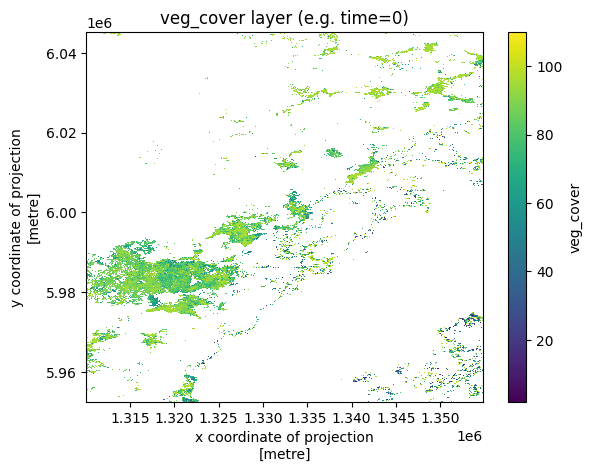

In [52]:
# Visualise veg_cover of the first time step

import matplotlib.pyplot as plt

veg_ds["veg_cover"].isel(time=0).plot()
plt.title("veg_cover layer (e.g. time=0)")
plt.show()

In [53]:
# Find coordinate of each observations in EPSG:32754

from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32754", always_xy=True)
df['dea_x'], df['dea_y'] = transformer.transform(df['X'].values, df['Y'].values)
df.head()

<ipython-input-53-70a1546ec723>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dea_x'], df['dea_y'] = transformer.transform(df['X'].values, df['Y'].values)
<ipython-input-53-70a1546ec723>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dea_x'], df['dea_y'] = transformer.transform(df['X'].values, df['Y'].values)


,SiteID,X,Y,Datetime,Temperature,RH,VPD,slope,aspect,relief,dea_x,dea_y
0,79,150.2953,-35.48254,2019-01-20 04:00:00,17.941,97.525473,0.050885,7.769969,187.297363,27.341133,1.344411e+06,6.033478e+06
1,79,150.2953,-35.48254,2019-01-20 05:00:00,17.753,97.881611,0.043049,7.769969,187.297363,27.341133,1.344411e+06,6.033478e+06
2,79,150.2953,-35.48254,2019-01-20 06:00:00,17.878,98.236778,0.036114,7.769969,187.297363,27.341133,1.344411e+06,6.033478e+06
3,79,150.2953,-35.48254,2019-01-20 07:00:00,18.066,97.406114,0.053760,7.769969,187.297363,27.341133,1.344411e+06,6.033478e+06
4,79,150.2953,-35.48254,2019-01-20 08:00:00,18.379,97.881611,0.044776,7.769969,187.297363,27.341133,1.344411e+06,6.033478e+06


In [63]:
# Fill in veg cover in df row by row

def get_veg_cover(row):
    x = row['dea_x']
    y = row['dea_y']
    t = row['Datetime']

    try:
        # Select data at the given location across all times
        point_series = veg_ds.sel(x=x, y=y, method='nearest')['veg_cover']

        # Drop NaNs
        valid_series = point_series.dropna(dim='time')

        if valid_series.sizes['time'] == 0:
            return np.nan

        # Find the nearest time, within 30 days, with non-NaN veg_cover
        time_deltas = np.abs(valid_series['time'] - np.datetime64(t))
        if time_deltas.min() > np.timedelta64(30, 'D'):
            print("min time_deltas: ", time_deltas.min() / np.timedelta64(1, 'D'))
            return np.nan
        nearest_idx = time_deltas.argmin().item()
        veg_cover = valid_series.isel(time=nearest_idx).item()

        return veg_cover if veg_cover < 100 else 100

    except Exception:
        return np.nan

df['veg_cover'] = df.apply(get_veg_cover, axis=1)
df.head()

,SiteID,X,Y,Datetime,Temperature,RH,VPD,slope,aspect,relief,dea_x,dea_y,veg_cover
4215,71,150.2904,-35.48805,2019-01-03 13:00:00,27.753,62.048446,1.414040,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,96.400002
4216,71,150.2904,-35.48805,2019-01-03 14:00:00,27.191,67.014198,1.189299,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,96.400002
4217,71,150.2904,-35.48805,2019-01-03 15:00:00,25.691,71.861717,0.928711,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,96.400002
4218,71,150.2904,-35.48805,2019-01-03 16:00:00,26.379,69.799005,1.038156,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,96.400002
4219,71,150.2904,-35.48805,2019-01-03 17:00:00,26.004,72.681525,0.918511,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,96.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4523,71,150.2904,-35.48805,2019-01-16 09:00:00,24.691,86.967100,0.405315,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,97.099998
4524,71,150.2904,-35.48805,2019-01-16 10:00:00,27.691,75.790739,0.898757,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,97.099998
4525,71,150.2904,-35.48805,2019-01-16 11:00:00,29.065,71.998515,1.125869,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,97.099998
4526,71,150.2904,-35.48805,2019-01-16 12:00:00,31.000,64.474648,1.596009,7.369228,7.677246,26.131332,1.343906e+06,6.032907e+06,97.099998


In [64]:
df[~df['veg_cover'].isna()]

TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'

In [26]:
df.drop(columns=['dea_x', 'dea_y'], inplace=True)
df

,SiteID,X,Y,Datetime,Temperature,RH,VPD,slope,aspect,relief,veg_cover


# Save df to csv

In [27]:
# save df
df.to_csv(os.path.join(output_dir, 'in-situ_topography_phd.csv'), index=False)
df

,SiteID,X,Y,Datetime,Temperature,RH,VPD,slope,aspect,relief,veg_cover


In [28]:
stop

NameError: name 'stop' is not defined

# Notes

## Investigation of correctness of codes above


In [ ]:
# Check for accuracy of the veg_cover section

# Check for NaN and deal with it
df.isna().sum()  # 9661 rows

# Check for sites with some rows with NaN veg_cover
df[df["veg_cover"].isna()]["SiteID"].unique()  # Not all sites

# Check for sites with all rows with NaN veg_cover
nan_sites = df.groupby("SiteID")["veg_cover"].apply(lambda x: x.isna().all())
nan_siteIDs = nan_sites[nan_sites].index.tolist()
nan_siteIDs  # 0 site

# Inspect different dates
df[df['Datetime'].dt.strftime('%Y-%m-%d') == '2018-12-21']  # 120 rows
df[df['Datetime'].dt.strftime('%Y-%m-%d') == '2019-01-20'].isna().sum()  # 48 rows
df[df['Datetime'].dt.strftime('%Y-%m-%d') == '2019-01-20']  # 120 rows

In [ ]:
# Investigate whether I need to redownload the veg_cover data from NCI because of its insufficient coverage

# Check whether the veg_cover of SiteID 67, 68, 69, 70 on 2018-12-21 are NaN or not
df = pd.read_csv(os.path.join(output_dir, 'in-situ_topography_with_NaN_veg_cover.csv'))
df['Datetime'] = pd.to_datetime(df['Datetime'])
first_date_df = df[df['SiteID'].isin([67, 68, 69, 70]) & (df['Datetime'].dt.strftime('%Y-%m-%d') == '2018-12-21')]
first_date_df['SiteID'].unique()

# Check the last date
last_date_df = df[df['SiteID'].isin([302, 303, 304, 305]) & (df['Datetime'].dt.strftime('%Y-%m-%d') == '2020-11-06')]
last_date_df['SiteID'].unique()

In [ ]:
# Investigate site 302

df = pd.read_csv(os.path.join(output_dir, 'in-situ_topography.csv'))
df['Datetime'] = pd.to_datetime(df['Datetime'])
df[df['SiteID'].isin([302]) & (df['Datetime'].dt.strftime('%Y-%m-%d') == '2020-11-06')]

In [ ]:
# Investigate change in vegetation cover.
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32754", always_xy=True)
dea_x, dea_y = transformer.transform(150.3096, -35.46728)
point_series = veg_ds.sel(x=dea_x, y=dea_y, method='nearest')['veg_cover']
print(point_series.values)

# visualise the point_series
point_series.plot()
plt.title("Vegetation cover of site 302")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

dem_path = os.path.join(working_dir, "output", "batemans_bay_dem_no_neg.tif")
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)

    lon = sites_with_nans_df['X'].tolist()
    lat = sites_with_nans_df['Y'].tolist()
    x_proj, y_proj = transform('EPSG:4326', src.crs, lon, lat)
    rows, cols = rowcol(src.transform, x_proj, y_proj)

plt.imshow(dem_data, cmap='terrain')
plt.scatter(cols, rows, color='red', s=10)
plt.colorbar(label='DEM (metres)')
plt.title('DEM Map')
plt.show()

## Others

In [ ]:
url = "https://data.dea.ga.gov.au/derivative/ga_ls_fc_3/2-5-1/090/084/2015/01/02/ga_ls_fc_3_090084_2015-01-02_final_veg_cover.tif"
download_file(url, os.path.join(working_dir, "data", "test.tif"))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(mosaic[0], cmap='terrain')
plt.colorbar(label='Slope (degrees)')
plt.title('Slope Map')
plt.show()

In [ ]:
# TODO (HIGH): Update df with the new code. Below is not usable.
# add_data_to_df('slope')
# orig_len = len(df)
# df = df[(df['slope'] != np.nan) & (df['slope'] != -9999.0)]
# print("Remove rows with no slope data.")
# print(f"There are {orig_len - len(df)} rows out of {orig_len} rows with no slope data.")
# add_data_to_df('aspect')
# add_data_to_df('relief')

In [ ]:
# Visualise relief calculated
# TODO (LOW): Correct scaling of the plot

import matplotlib.pyplot as plt

relief_path = os.path.join(working_dir, "output", "batemans_bay_relief.tif")
with rasterio.open(relief_path) as src:
    relief_data = src.read(1)

    lon = sites_with_nans_df['X'].tolist()
    lat = sites_with_nans_df['Y'].tolist()
    x_proj, y_proj = transform('EPSG:4326', src.crs, lon, lat)
    rows, cols = rowcol(src.transform, x_proj, y_proj)

plt.imshow(relief_data, cmap='terrain')
plt.scatter(cols, rows, color='red', s=10)
plt.colorbar(label='Relief (metres)')
plt.title('Relief Map')
plt.show()